# Лекция 4: Свреточные нейронные сети

__Автор: Сергей Вячеславович Макрушин__ e-mail: SVMakrushin@fa.ru 

Финансовый универсиет, 2021 г. 

При подготовке лекции использованы материалы:
* ...

v 0.7 23.03.21 keras перенесен в конец; сделано оглавление

In [2]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v2.css")
HTML(html.read().decode('utf-8'))

__Сверточные нейронные сети__ (convolutional neural networks, CNN) — класс архитектур ИНС, основная идея которых состоит в том, чтобы переиспользовать одни и те же части нейронной сети для работы с разными локальными участками входов. 
* Идея сверточных сетей основана на результатах исследований зрительной коры головного мозга
* Изначально основным приложением сверточных нейронных сетей является __обработка изображений__. 
* Обработка изображений до сих пор является одиним из основных приложений для сверточных сетей, однако существует множество примеров применения сверточных нейронных сетей в самых различных областях.


## Представления о принципах обработки изображений в мозге человека <a class="anchor" id="вмозге"></a>
* [к оглавлению](#разделы)

__Биологические предпосылки к созданию сверточных нейронных сетей__

Зрительный нерв — толстый пучок аксонов ганглионарных клеток, по которому информация с сетчатки доходит до мозга. 
* Зрительный нерв входит в таламус, отдел мозга, обрабатывающий информацию от органов чувств, там первичная обработка происходит в так называемом латеральном коленчатом теле (lateral geniculate nucleus, LGN)
* затем зрительная информация от LGN поступает в зрительную кору (visual cortex).
* __Зрительная кора__ расположена сзади, в затылочной доле головного мозга. Она __делится на несколько частей__, которые обычно называются зрительная зона V1 (visual area one), зрительная зона V2 (visual area two) и т. д., до V6 и V7. 
* Зоны __отличаются__ друг от друга __физиологией__, __архитектурой__ да и просто обособленным положением в коре, и исследователи не сомневаются, что они __различаются и по своим функциям__. Хотя до сих пор функциональная специализация зон пока что до конца не ясна, понятно, что функции зон зрительной коры становятся постепенно все более и более общими.

__Разделение функциональности различных зон визуальной коры__

По нынешним представлениям:
* в зоне V1 выделяются __локальные признаки небольших участков считанного с сетчатки изображения__; это для нас сейчас самое интересное, и об этом мы подробно поговорим ниже;
* V2 продолжает __выделять локальные признаки, слегка обобщая__ их и добавляя бинокулярное зрение (то есть стереоэффект от двух глаз);
* в зоне V3 распознается __цвет, текстуры объектов__, появляются первые результаты их __сегментации и группировки__;
* зона V4 уже начинает распознавать __геометрические фигуры и очертания объектов__, пока несложных; кроме того, именно здесь наиболее сильна __модуляция посредством нашего внимания__: активация нейронов в V4 не равномерна по всему полю зрения, а сильно зависит от того, на что мы осознанно или неосознанно обращаем внимание;
* зона V5 в основном __занимается распознаванием движений__, пытаясь понять, куда и с какой скоростью передвигаются в зоне видимости те самые объекты, очертания которых выделились в зоне V4;
* в зоне V6 __обобщаются данные о всей картинке__, она реагирует на изменения по всему полю зрения (wide-field stimulation) и изменения в картинке вследствие того, что передвигается сам человек;
* иногда также выделяют зону V7, где происходит __распознавание сложных объектов__, в частности человеческих лиц.

<center>     
    <img src="./img/nnn_2.png" alt="Изображения двухмерные" style="width: 550px;"/>
    <strong>Функциональность различных зон визуальной коры</strong>
</center>


Данная __функциональная специализация хорошо соответствует логике глубоких ИНС__: более высокие уровни нужны для того, чтобы выделять более общие признаки, соответствующие абстрактным свойствам входа, а на нижних уровнях
признаки более конкретные. 

__Иерархия среди зон не очень строгая__: есть масса прямых связей, когда, например, нейроны из зоны V1 подаются на вход не только в зону V2, но и напрямую в зону V5. Анлогичных подходы используются и в сверточных архитектурах ИНС.
Считается , что внимание, которое зарождается в зоне V4, потом переходит обратно к V2 и V1 

__Зона визуальной коры V1__

<center>     
    <img src="./img/nnn_1.png" alt="Изображения двухмерные" style="width: 550px;"/>
    <strong>Изучение первичной зрительной коры</strong>
</center>

Наиболее хорошо изучена зона V1 (первичная зрительная кора): 
* она ближе всего к собственно входам
* достаточно просто устроена
* (=>) в ней проще понять, за что «отвечают» отдельные нейроны и как они друг с другом взаимодействуют

Зона V1 сама состоит из шести уровней нейронов: 
* входные сигналы приходят из латерального коленчатого тела в четвертый уровень, 
* дальнейшие сигналы выходят из уровней 2 и 3, 
* а обратная связь — из шестого. 

* Нейроны в зоне V1 располагаются не случайно: зона V1 содержит полную «карту» полей зрения обоих глаз, то есть __близкие участки сетчатки обрабатываются близкими нейронами в V1__.
* при «картировании» локальная структура переносится очень точно, а вот на глобальном уровне есть серьезные искажения: 
    * во-первых, __центральный участок поля зрения сильно увеличен__ (половина всех нейронов отвечают за 2 % поля зрения), 
    * во-вторых, есть геометрические искажения, __похожие на использование полярных координат__: концентрические круги и радиальные линии на картинке преобразуются в вертикальные и горизонтальные линии в V1. Это позволяет сохранять инвариантность изображения при смене нашей позиции и угла зрения.
    
Клетки зоны V1 подразделялись на простые и сложные:
* Простые клетки реагируют только на участки и полосы света, края стимулов, проходящих в определенном месте под определенным углом. 
* Сложные клетки могут, например, реагировать на ориентацию независимо от конкретного положения сигнала. 

Сложные клетки относятся к следующему уровню обработки, получая на вход результат активации простых клеток; поэтому их рецептивное поле обычно немного больше, а выявляемые ими признаки оказываются инвариантными к местоположению сигнала.     

__Для логики сверточных ИНС важно что каждый нейрон в V1 работает с очень маленьким участком изображения (он называется рецептивным полем, receptive field), и между ними сохраняются пространственные взаимосвязи, подобные исходной картинке.__

## Разделы: <a class="anchor" id="разделы"></a>
* [Представления о принципах обработки изображений в мозге человека](#вмозге)
* [Сверточные сети](#сс)
* [Оценка качества моделей](#качество)
* [Решение задачи двухклассовой классификации](#двухклассовая)
    * [Создание тензоров](#создание-тензоров)
    * [Операции с тензорами](#операции-тензоры)    
        * [Арифметические операции и математические функции:](#aрифметические)        
        * [Операции, изменяющие размер тензора](#размер)        
        * [Операции агрегации](#агрегации)        
        * [Матричные операции](#aрифметические)                
-

* [к оглавлению](#разделы)

---
## Нормализация <a class="anchor" id="нормализация"></a>
* [к оглавлению](#разделы)

## Сверточные сети <a class="anchor" id="сс"></a>
* [к оглавлению](#разделы)

__Специфика изображений как исходных данных__


* __Изображения двухмерные:__

<center>     
    <img src="./img/conv_1.png" alt="Изображения двухмерные" style="width: 400px;"/>
    <strong>Изображения двухмерные</strong>
</center>

* Данные в изображениях имеют пространственную структуру, закодированную в виде стуркутуры массива, хранящего информацию о пикселях

<br/>

* __В большинстве случаев афиинные (и многие более сложные) преобразования не меняют смысл изображения__ (при этом массив входных данных меняется кардинально)
<center>     
    <img src="./img/conv_1_2.png" alt="афиинные преобразования не меняют смысл изображения" style="width: 400px;"/>
    <strong>Многие преобразования не меняют смысл изображения</strong>
</center>

<br/>

* __Двухмерные изображения часто имеют несколько каналов__ (фактически изображение представляется как тензор: Высота \* Ширина \* Количество_каналов)

<center>     
    <img src="./img/conv_2.png" alt="Двухмерные изображения часто имеют несколько каналов" style="width: 500px;"/>
    <strong>Двухмерные изображения часто имеют несколько каналов</strong>
</center>

* Объем данных хранящийся даже в одной небольшой картинке очень вилик (например RGB изображения 256\*256 пикселей хранит ~200 тыс. значений)

<br/>

<center>     
    <img src="./img/conv_3.png" alt="Значения соседних пикселов сильно скореллированы" style="width: 400px;"/>
    <strong>Значения соседних пикселей сильно скореллированы</strong>
</center>

__Идея сверточных сетей__

* При обучении __полносвязных нейронных сетей__ дополнительное __знание о структуре задачи не используется__. Но многие типы данных имеют свою собственную внутреннюю структуру,которая отлично известна нам заранее. Простой  пример такой структуры - изображение. 

* Кроме расположения пикселей в изображении, важную роль о взаимосвзи входных переменных могут нести: __временная ось__ (например в аудиозаписи), __последовательность__ (например для символов в тексте), время и пространственное расположение элементов входных данных могут присутствовать в датасете одновременно, например в видеозаписи.

* В изображении заранее известно какие пиксели являются соседними друг с другом. Но при решении задачи распознования изображения __полносвязной нейронной сети прийдется обучаться__  не только распознаванию изображений но и тому, что __некоторые компоненты входного вектора представляют собой соседние пиксели__, а значит, сильно скоррелированы.

* При решении подобных задач вместо полносвязных слоев нейронов целесообразно использовать __специализированные методы__, в которые уже __заложено представления об априорной структуре данных__.

Сверточные слои:
* изучают __локальные шаблоны__ (в случае с изображениями — шаблоны в __небольших двумерных окнах__ во входных данных)
* изучают  шаблоны __инвариантные в отношениии переноса__ (шаблон будет с одинаковым качеством выявлен как в центре изображения, так и в левом нижнем углу, для полносвязной сети эти две задачи выглядели бы как совершенно разные задачи)

<center>     
    <img src="./img/conv_4.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 300px;"/>
    <strong>Локальные шаблоны в небольших двухмерных окнах</strong>
</center>

* Сверточный слой выделяет признаки в каждом окне небольшой нейронной сетью. В каждом окне выделяются одни и те же признаки, т.е. используется одна и та же маленькая нейронная сеть. Например, если окно 3 \* 3 пикселя, то входов у нее будет всего 9 и для каждого окна, в котором она будет применена, будет получен отдельный выход.

* Свертка — линейное преобразование входных данных особого вида. Если $x^l$ — карта признаков в слое под номером $l$, то результат двумерной свертки с ядром размера $2d + 1$ и матрицей весов $W$ размера $(2d + 1) × (2d + 1)$ на следующем слое будет таким:
$$y^l_{i,j}=\sum_{-d \le a,b \le d} W_{a,b}x^l_{i+a,j+b}$$
где $y^l_{i,j}$ - результат свертки на уровне $l$, а $x^l_{i,j}$ — ее вход, то есть выход всего предыдущего слоя.
* Почти всегда после свертки в нейронной сети следует нелинейность, которую можно записать так: $z^l_{i,j}=h(y^l_{i,j})$. В качестве функции $h$ может использоваться любая функция активации, в глубоких сетях обычно предпочитают функцию $ReLU$, но и классические функции $\sigma$ и $\tanh$ тоже встречаются.

<center>     
    <img src="./img/conv_10.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
    <strong>Пример подсчета результата свертки для ядра 3*3 и карты признаков размером 5*5: два примера подматрицы и общий результат</strong>
</center>

Примеры использования различны фильтров:

<center> 
    <img src="./img/conv_23.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
</center>

<center> 
    <img src="./img/conv_22.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
</center>

Фильтры Габора
<center> 
    <img src="./img/conv_21.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
</center>

<center> 
    <img src="./img/conv_24.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
</center>

__Применение одного слоя свертки к одному слою входных данных__

* Свертка работает __методом скользящего окна__: она двигает окно с размером ядра (например 3 \* 3) по трехмерной входной карте признаков, останавливается в каждой возможной позиции и извлекает трехмерный шаблон окружающих признаков (с формой *\[ высота\_окна, ширина\_окна, глубина\_входа \]* ). 
* Затем каждый __трехмерный шаблон преобразуется__ (путем умножения тензора на матрицу весов, получаемую в ходе обучения, которая называется ядром свертки) в одномерный вектор с формой *\[выходная глубина\]*. 
* Затем все эти векторы __собираются в трехмерную выходную карту__ с формой *\[высота\_окна, ширина\_окна, выходная\_глубина\]* * Каждое пространственное местоположение в выходной карте признаков соответствует тому же местоположению во входной карте признаков (например, правый нижний угол выхода содержит информацию о правом нижнем углу входа). 
* Размерность тензора сверточных весов определяется __размерами ядра свертки и числом каналов как на входе, так и на выходе__ (число каналов на входе и на выходе может не совпадать!). Таким обазом для двухмерного изображения тензор ядра свертки четырехмерный соследующими размерностями: *\[высота\_ядра, ширина\_ядра, входные\_каналы, выходные\_каналы\]*.

<center> 
<img src="./img/conv_6.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
</center>

__Изменение размеров карты признаков__

Выходные ширина и высота карты признаков могут отличаться от входных из-за:
* эффекта границ, который, при необходимости может устраняться дополнением входной карты признаков;
* использования шага свертки.
Изменения размеров карты признаков обычно не является проблемой, зачастую уменьшение размеров карты является даже желательным эффектом.

__Эффект границ__

Рассмотрим карту признаков 5 × 5 (всего 25 клеток). Существует всего 9 клеток, в которых может находиться центр окна 3 × 3, образующих сетку 3 × 3.  Следовательно, карта выходных признаков будет иметь размер 3 × 3. Она получилась немного сжатой: ровно на две клетки вдоль каждого измерения. 

Чтобы получить выходную карту признаков с теми же пространственными размерами, что и входная карта, можно использовать дополнение (padding). Дополнение  заключается в добавлении соответствующего количества строк и столбцов с каждой стороны входной карты признаков, чтобы можно было поместить центр окна свертки в каждую входную клетку. 

__Допустимые местоположения шаблонов 3 × 3 во входной карте признаков 5 \* 5__
<center> 
<img src="./img/conv_8.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 400px;"/>
</center>

В слое Conv2D дополнение настраивается аргумента _padding_ :
* значенияе _"valid"_ (по умолчанию) -  отсутствие дополнения (будут использоваться только допустимые местоположения окна),
* значенияе _"same"_ - карта дополняется так, чтобы выходная карта признаков имела ту же ширину и высоту, что и входная». 

__Шаг свертки__

В базовом методе скользящего окна предполагалось, что центральная клетка окна свертки последовательно перемещается в смежные клетки входной карты. В общем случае расстояние между двумя соседними окнами является настраиваемым параметром, который называется __шагом свертки__ и по умолчанию равен 1. Имеется возможность определять свертки с пробелами (strided convolutions) — свертки с шагом больше 1. На рисунке можно видеть, как извлекаются шаблоны 3 \* 3 сверткой с шагом 2 из входной карты 5 \* 5 (без дополнения).

__Шаблоны 3 \* 3 свертки с шагом 2 \* 2__
<center> 
    <img src="./img/conv_9.png" alt="Допустимые местоположения шаблонов" style="width: 500px;"/>
</center>

__Сравнение свертки и полносвязного слоя__

Пример 
* Пусть мы используем мини-батчи размером 32 изображения в каждом и обучаем сеть на RGB-изображениях лиц размером 28 × 28 пикселов => итоговая размерность тензора данных будет *\[32, 28, 28, 3\]* , размерность одного изображения  28 \* 28 \* 3 = 2352 чисел => всего в мини-батче ~75 тыс. чисел.
* Для свертки с ядром 3 \* 3 дающему на выходе 32 карты признаков, тензор будет иметь размерность *\[3, 3, 3, 32\]* =288 весов
* Т.к. на выходе болучится 26\*26 окон по 3\*3 т.е. получится карта признков размерностью *\[26, 26, 32\]* = 21 632 числа
* Для полносвязной сети портебовалось бы 28 \* 28 \* 3 \* 21 632 = 508 784 64 весов
* Разница количества весов в свертке и в полносвязной сети более 50 тыс. раз!

Результат:
* Форма операции свертки служит очень сильным регуляризатором, который выражает идеюо том, что выделение локальных признаков в изображении не должно зависеть от конкретного места, где эти признаки располагаются
* Для локальной сети, которая призвана выражать эти локальные признаки, резко увеличиваем объем данных на входе: теперь для нее фактически каждая картинка превращается в кучу маленьких тренировочных примеров.
* Учет соответствующих задаче инвариантов, меньше весов, больше примеров => процесс обучения сверточной сети по сравнению с полносвязной сильно упрощается.

__Max-pooling__

В классическом сверточном слое, кроме линейной свертки и следующей за ней нелинейности, есть и еще одна операция: __субдискретизация (pooling)__.

Смысл субдискретизации прост: 

* В сверточных сетях обычно исходят из предположения, что __наличие или отсутствие__ того или иного признака гораздо __важнее, чем его точные координаты__.
* Для этого проводится «обобщение» выделяемых признаков, с потерей части информации об их местоположении, но это позволяет __сократить размерность задачи__.
* Для уменьшения разрешения карты признаков вместо шага свертки обычно используется операция выбора __максимального значения из соседних (max-pooling)__.

Операция max-pooling заключается в следующем: из входной карты признаков извлекается окно, и из него выбирается максимальное значение для каждого канала: 
$$x^{l+1}_{i,j}=\underset{{-d \le a,b \le d}}{\max} z^l_{i+a, j+b}$$
результат передается на вход следующему слою.

Концептуально это напоминает свертку, но вместо преобразования локальных шаблонов с обучением на линейных преобразованиях 
(ядро свертки) они преобразуются с использованием жестко заданной тензорной операции выбора максимального значения. 

__Пример субдискретизации с окном размера 2 \* 2__
<center> 
<img src="./img/conv_11.png" alt="Допустимые местоположения шаблонов" style="width: 500px;"/>
</center>
а — исходная матрица; б — матрица после субдискретизации с шагом 1; в — матрица после субдискретизации с шагом 2.

Хотя в результате субдискретизации действительно теряется часть информации, сеть становится более устойчивой к небольшим трансформациям изображения вроде сдвига или поворота.

__Схема стандратного слоя сверточной сети__

Стандартный слой сверточной сети состоит из трех компонентов:
* свертка в виде линейного отображения, выделяющая локальные признаки;
* нелинейная функция, примененная покомпонентно к результатам свертки;
* субдискретизация, которая обычно сокращает геометрический размер получающихся тензоров.

__Схема одного слоя сверточной сети__
<center> 
<img src="./img/conv_12.png" alt="Схема одного слоя сверточной сети" style="width: 500px;"/>
</center>

__Иерархии сверточных сетей__

Проблема: __один сверточный слой не сможет выразить взаимосвязь между пикселами, расположенными далеко друг от друга__.

* Для решения проблемы, будем строить __глубокие сверточные сети__: выход одной сверточной сети будем подавать на вход следующей сверточной сети. 

* будем строить __пространственные иерархии шаблонов__ 
    * Первый сверточный слой будет изучать небольшие локальные шаблоны, такие как края, второй — более крупные шаблоны, состоящие из признаков, возвращаемых первым слоем, и т. д. 
    * Такой подход позволяет сверточным ИНС эффективно изучать все сложные и абстрактные визуальные представления (и это важно, т.к. мир по своей сути является пространственно-иерархическим).
    
__Принцип построения иерархии сверточных сетей__
<center> 
<img src="./img/conv_7.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 450px;"/>
</center>

__Типичная архитектура сети распознавания изображений__
<center> 
<img src="./img/conv_13.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 600px;"/>
</center>

<center> 
<img src="./img/conv_14.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 600px;"/>
</center>

<center> 
<img src="./img/conv_15.png" alt="могут изучать пространственные иерархии шаблонов" style="width: 600px;"/>
</center>

TODO: распространение градиентов Ник195
TODO: Переход к маленьким шаблонам Ник206+Лекции+...

### Пример решения задачи

Задача: распознавание цифр

Мы будем проводить обучение сверточной сети на наборе данных MNIST. Это один из самых известных, самых избитых наборов
данных как распознавания изображений в целом, так и глубокого обучения в частности. Для современных методов решения задача распознавания цифр в MNIST уже никаких сложностей не представляет, но она остается очень популярной как базовый учебный пример.

__Набор данных MNIST: примеры рукописных цифр__
<center> 
<img src="./img/conv_16.png" alt="Набор данных MNIST: примеры рукописных цифр" style="width: 400px;"/>
</center>

* MNIST состоит из рукописных цифр, изображенных на американский манер. 
* Всего в MNIST содержится 70 000 размеченных черно-белых изображений размером 28 × 28 пикселов; 
* «размеченных» здесь означает, что каждому изображению в данных уже поставлен в соответствие правильный ответ — цифра, которую хотел изобразить человек на этой картинке.

Examples:
* https://nextjournal.com/gkoehler/pytorch-mnist
* https://github.com/pytorch/examples/blob/master/mnist/main.py
* https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist

In [1]:
# Пример на основе: https://nextjournal.com/gkoehler/pytorch-mnist

import torch
import torchvision
import torchvision.datasets as datasets

# построение сети:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# рисование:
import matplotlib.pyplot as plt

In [2]:
# Параметры модели:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

In [3]:
# Обеспечиваем детерминированность результата:
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
ls

 ’®¬ ў гбва®©бвўҐ C ­Ґ Ё¬ҐҐв ¬ҐвЄЁ.
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : D65B-CBD9

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ C:\Users\‘ҐаЈҐ©\YandexDisk\Python\Ipynb\ML_DL_2021\lec04_Convol

23.03.2021  11:44    <DIR>          .
23.03.2021  11:44    <DIR>          ..
23.03.2021  11:23    <DIR>          .ipynb_checkpoints
12.03.2021  11:53    <DIR>          data
12.03.2021  11:16    <DIR>          img
12.03.2021  11:16             2я835 lec_v2.css
12.03.2021  11:16           602я941 ML_NLP_l07_v4.ipynb
12.03.2021  11:16         3я336я578 ML_NLP_l07_v4.pdf
12.03.2021  11:16           611я576 MLDL21_lec04_Conv_v5_.ipynb
18.03.2021  21:25         3я407я299 MLDL21_lec04_Conv_v6 - Jupyter Notebook.pdf
23.03.2021  11:23           875я732 MLDL21_lec04_Conv_v6_with_keras.ipynb
23.03.2021  11:44           858я646 MLDL21_lec04_Conv_v7.ipynb
22.03.2021  16:10    <DIR>          results
22.03.2021  11:52             1я805 tmp_ml_convol_v1.ipynb
               8 д ©«®ў      9я697я412 Ў ©в
               6 Ї Ї®Є  14я302я437я376 Ў ©в бў®Ў®¤

In [5]:
# download=False becouse http://yann.lecun.com/exdb/mnist/ ## HTTP Error 503: Service Unavailable
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root="./data/", train=True, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(root="./data/", train=False, download=False,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [6]:
# Рассмотрим что представляют из себя данные: 

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

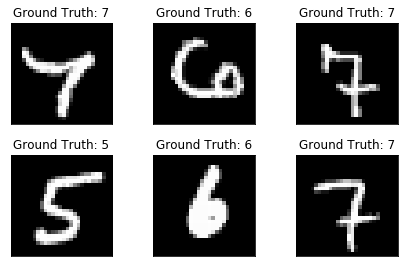

In [7]:
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
# fig

`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')`
* `in_channels` (int) – Number of channels in the input image ($C_{in}$)
* `out_channels` (int) – Number of channels produced by the convolution ($C_{out}$)
* `kernel_size` (int or tuple) – Size of the convolving kernel

Shape:
* Input: $(N, C_{in}, H_{in}, W_{in})$
* Output: $(N, C_{out}, H_{out}, W_{out})$


`torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)` - Applies a 2D max pooling over an input signal composed of several input planes
* `kernel_size` – the size of the window to take a max over
* `stride` – the stride of the window. __Default value is kernel_size__
* `padding` – implicit zero padding to be added on both sides
* `dilation` – a parameter that controls the stride of elements in the window
* `return_indices` – if True, will return the max indices along with the outputs. Useful for torch.nn.MaxUnpool2d later
* `ceil_mode` – when True, will use ceil instead of floor to compute the output shape

$$H_{out} = \left\lfloor\frac{H_{in} + 2 \times \text{padding}[0] - \text{dilation}[0] \times (\text{kernel_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor$$

In [8]:
ex1 = example_data
print('ex1:', ex1.shape)

conv1 = nn.Conv2d(1, 10, kernel_size=5)
ex2 = conv1(ex1)
print('ex2:', ex2.shape)
ex3 = F.max_pool2d(ex2, 2)
print('ex3:', ex3.shape)

conv2 = nn.Conv2d(10, 20, kernel_size=5)
ex4 = conv2(ex3)
print('ex4:', ex4.shape)
ex5 = F.max_pool2d(ex4, 2)
print('ex5:', ex5.shape)

ex1: torch.Size([1000, 1, 28, 28])
ex2: torch.Size([1000, 10, 24, 24])
ex3: torch.Size([1000, 10, 12, 12])
ex4: torch.Size([1000, 20, 8, 8])
ex5: torch.Size([1000, 20, 4, 4])


In [9]:
# класс нейронной сети:

# nn (torch.nn) - layers as which contain trainable parameters
# F (torch.nn.functional) - purely functional

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d() # p=0.5
        self.fc1 = nn.Linear(20*4*4, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # первый сверточный слой
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2)) # второй сверточный слой
        x = x.view(-1, 20*4*4) # в двухмерный тензор с shape: (batch, 20*4*4)
        x = F.relu(self.fc1(x)) # первый полносвязный слой
        x = F.dropout(x, training=self.training)
        x = self.fc2(x) # второй полносвязный слой
        return F.log_softmax(x)
    
    def forward_1l(self, x):    
        x = F.relu(F.max_pool2d(self.conv1(x), 2)) # первый сверточный слой
        return x

In [10]:
# создаем сеть:
network = Net()

# создаем оптимизатор:
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [11]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [12]:
def train(epoch):
    network.train() # has any effect only on certain modules e.g. Dropout, BatchNorm, etc.
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        # negative log likelihood loss. It is useful to train a classification problem with C classe:        
        loss = F.nll_loss(output, target) 
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset), 
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [13]:
# a = torch.randn(4, 4)
# print(a)
# am = torch.argmax(a, dim=1, keepdim=True)
# print(am)

In [14]:
def test(debug=False):
    network.eval() # equivalent with self.train(False)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data)
#             test_loss += F.nll_loss(output, target, size_average=False).item()
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
    
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()    
    
#             pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
#             correct += pred.eq(target.data.view_as(pred)).sum()
            if debug:
                return output
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 
        100. * correct / len(test_loader.dataset)))

In [15]:
# network.train()
# network.eval()

# F.nll_loss(output, target, size_average=False).item()
# # size_average

In [16]:
o1 = test(debug=True)
o1

C:\ProgramData\Anaconda3\envs\pyTorch_1_6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.4314, -2.3174, -2.3548,  ..., -2.1659, -2.2296, -2.1946],
        [-2.3998, -2.3836, -2.3131,  ..., -2.2006, -2.2663, -2.2003],
        [-2.3856, -2.4529, -2.3388,  ..., -2.2313, -2.1910, -2.1097],
        ...,
        [-2.3745, -2.3583, -2.4331,  ..., -2.2168, -2.1484, -2.2051],
        [-2.5067, -2.3910, -2.3380,  ..., -2.1456, -2.1089, -2.1038],
        [-2.4255, -2.3816, -2.3940,  ..., -2.1900, -2.2582, -2.1412]])

In [17]:
test()
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\ProgramData\Anaconda3\envs\pyTorch_1_6\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 2.3064, Accuracy: 1063/10000 (11%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.325641
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.296966
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.281457
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.282858
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.273702
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.227460
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.230552
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.204216
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.075135
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.006494
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.947456
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.961289
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.731466
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.594168
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.494745
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.355648
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.461957
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.325251
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.519567
Train Epoch: 1 [12160

Train Epoch: 2 [43520/60000 (72%)]	Loss: 0.580916
Train Epoch: 2 [44160/60000 (74%)]	Loss: 0.501193
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.341426
Train Epoch: 2 [45440/60000 (76%)]	Loss: 0.325942
Train Epoch: 2 [46080/60000 (77%)]	Loss: 0.426631
Train Epoch: 2 [46720/60000 (78%)]	Loss: 0.352939
Train Epoch: 2 [47360/60000 (79%)]	Loss: 0.289185
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.246044
Train Epoch: 2 [48640/60000 (81%)]	Loss: 0.365754
Train Epoch: 2 [49280/60000 (82%)]	Loss: 0.261719
Train Epoch: 2 [49920/60000 (83%)]	Loss: 0.272006
Train Epoch: 2 [50560/60000 (84%)]	Loss: 0.300097
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.349064
Train Epoch: 2 [51840/60000 (86%)]	Loss: 0.538915
Train Epoch: 2 [52480/60000 (87%)]	Loss: 0.293464
Train Epoch: 2 [53120/60000 (88%)]	Loss: 0.221189
Train Epoch: 2 [53760/60000 (90%)]	Loss: 0.177603
Train Epoch: 2 [54400/60000 (91%)]	Loss: 0.187486
Train Epoch: 2 [55040/60000 (92%)]	Loss: 0.262681
Train Epoch: 2 [55680/60000 (93%)]	Loss: 0.281255


Text(0, 0.5, 'negative log likelihood loss')

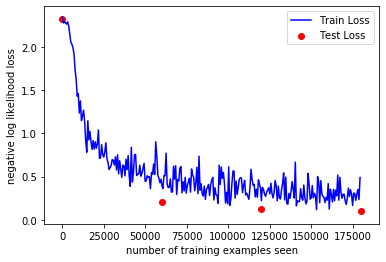

In [48]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
# fig

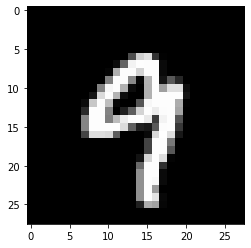

In [28]:
img_n = 42
plt.imshow(example_data[42,0], cmap='gray')
plt.show()

===

In [31]:
example_data[42,0]

tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
         -0.4242, -0.4242, -0.4242, -0.4242, -0.4242

In [68]:
data1, target1 = next(iter(test_loader))
print(data1.shape, target1.shape)

img_n = 42
img_row = 5 
img_col = 6
img_qty = img_row * img_col

data1_part = data1[img_n:img_n+img_qty, :, :, :]
target1_part = target1[img_n:img_n+img_qty]
print(data1_part.shape, target1_part.shape)

output = network(data1_part)
# test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
# +=
print(pred.shape, pred[5].item())
correct = pred.eq(target1_part.view_as(pred)).sum().item()    
print(correct)

torch.Size([1000, 1, 28, 28]) torch.Size([1000])
torch.Size([30, 1, 28, 28]) torch.Size([30])
torch.Size([30, 1]) 6
29


C:\Users\alpha\.conda\envs\pyTorch_1_5v2\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


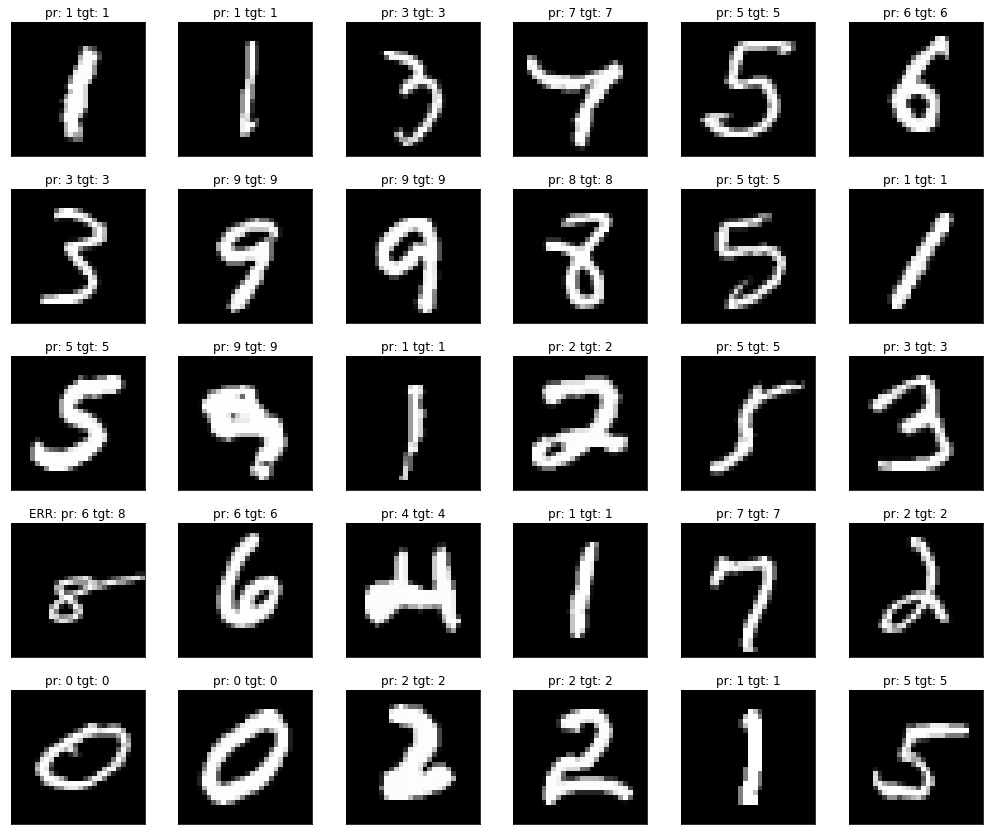

In [72]:
fig = plt.figure(figsize=(14,12))

for i in range(img_qty):
    plt.subplot(img_row, img_col, i+1)
    plt.tight_layout()
    plt.imshow(data1_part[i][0], cmap='gray', interpolation='none')
    if pred[i].item() == target1_part[i]:
        plt.title(f"pr: {pred[i].item()} tgt: {target1_part[i]}")
    else:
        plt.title(f"ERR: pr: {pred[i].item()} tgt: {target1_part[i]}")        
    plt.xticks([])
    plt.yticks([])

----

Ссылки:
* источник: https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e
* код: https://github.com/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb
* ---
* https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/
* https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
* https://medium.com/intelligentmachines/implementation-of-class-activation-map-cam-with-pytorch-c32f7e414923
* ---
* https://nextjournal.com/gkoehler/pytorch-mnist
* https://github.com/pytorch/examples/blob/master/mnist/main.py
* https://www.kaggle.com/sdelecourt/cnn-with-pytorch-for-mnist


__Приемы для обучения лубокому обучению на небольших наборах изображений__

__Расширение данных__

Причиной переобучения является недостаточное количество образцов для обучения модели, способной обобщать новые данные. Имея бесконечный объем данных, можно было бы получить модель, учитывающую все аспекты распределения данных: эффект переобучения никогда не наступил бы. Прием расширения данных реализует подход создания дополнительных обучающих данных из имеющихся путем трансформации образцов множеством случайных преобразований, дающих правдоподобные изображения. Цель состоит в том, чтобы на 
этапе обучения модель никогда не увидела одно и то же изображение дважды. 

Это поможет модели выявить больше особенностей данных и достичь лучшей степени обобщения.Сделать это в Keras можно путем настройки ряда случайных преобразований для изображений:
* rotation_range — величина в градусах (0–180), диапазон, в котором будет осуществляться случайный поворот изображения;
* width_shift и height_shift — диапазоны (в долях ширины и высоты), в пределах которых изображения смещаются по горизонтали и вертикали соответственно;
* shear_range — для случайного применения сдвигового (shearing) преобразования;
* zoom_range — для случайного изменения масштаба внутри изображений
* horizontal_flip — для случайного переворачивания половины изображения по горизонтали — подходит в случае отсутствия предположений о горизонтальной асимметрии (например, в изображениях реального мира);
* fill_mode — стратегия заполнения вновь созданных пикселов, появляющихся после поворота или смещения по горизонтали/вертикали.

__Изображения с кошкой, полученные применением случайных расширений__
<center> 
<img src="./img/conv_20.png" alt="Замена классификаторов при использовании одной и той же сверточной основы" style="width: 400px;"/>
</center>

__Использование предварительно обученной глубокой нейронной сети__

Типичным и эффективным подходом к глубокому обучению на небольших наборах изображений является использование предварительно обученной сети. __Предварительно обученная сеть__ — это сохраненная сеть, прежде обученная на большом наборе данных, обычно в рамках масштабной задачи классификации изображений. Если этот исходный набор данных достаточно велик и достаточно обобщен, тогда пространственная иерархия признаков, изученных сетью, может эффективно выступать в роли обобщенной модели видимого мира и быть полезной во многих разных задачах распознавания образов, даже если эти новые задачи будут связаны с совершенно иными классами, отличными от классов в оригинальной задаче. 

Например, можно обучить сеть на изображениях из ImageNet (где подавляющее большинство классов — животные и бытовые предметы) и затем использовать эту обученную сеть для идентификации чего-то иного, например предметов мебели на изображениях. 

Такая переносимость изученных признаков между разными задачами — главное преимущество глубокого обучения перед многими более старыми приемами поверхностного обучения, которое делает глубокое обучение очень эффективным инструментом для решения задач с малым объемом данных.

__Замена классификаторов при использовании одной и той же сверточной основы__
<center> 
<img src="./img/conv_18.png" alt="Замена классификаторов при использовании одной и той же сверточной основы" style="width: 400px;"/>
</center>

__Дообучение__

Другой широко используемый прием повторного использования модели, допол-
няющий выделение признаков, — дообучение (fine-tuning) (рис. 5.19). Дообучение 
заключается в размораживании нескольких верхних слоев замороженной модели, 
которая использовалась для выделения признаков, и совместном обучении вновь 
добавленной части модели (в данном случае полносвязного классификатора) 
и этих верхних слоев. Этот прием называется дообучением, поскольку немного кор-
ректирует наиболее абстрактные представления в повторно используемой модели, 
чтобы сделать их более актуальными для данной задачи.

__Дообучение последнего сверточного блока сети__
<center> 
<img src="./img/conv_19.png" alt="Дообучение последнего сверточного блока сети" style="width: 200px;"/>
</center>

### Визуализация знаний, заключенных в сверточной нейронной сети



Часто говорят, что модели глубокого обучения — это «черные ящики»: изученные ими представления сложно извлечь и представить в форме, понятной человеку. 

Отчасти это верно для некоторых типов моделей глубокого обучения, но уж точно не относится к сверточным нейронным сетям. Представления, изученные сверточными нейронными сетями, легко поддаются визуализации, в частности:
* визуализация промежуточных выводов сверточной нейронной сети (промежуточных активаций) — помогает понять, как последовательность слоев сети преобразует свои входные данные, а также показывает смысл отдельных фильтров;
* визуализация фильтров сверточной нейронной сети — помогает точно узнать, за какой визуальный шаблон или понятие отвечает каждый фильтр;
* визуализация тепловых карт активации класса в изображении — помогает понять, какие части изображения идентифицируют принадлежность к заданному классу, что позволяет выявлять объекты на изображениях.

__Визуализация промежуточных активаций__

* Визуализация промежуточных активаций заключается в отображении карт признаков, которые выводятся разными сверточными и объединяющими слоями в сети в ответ на определенные входные данные (вывод слоя, результат функции активации, часто называют его активацией). 
* Этот прием позволяет увидеть, как  входные данные разлагаются на различные фильтры, полученные сетью в процессе обучения. 
* Каналы кодируют относительно независимые признаки, поэтому для визуализации этих карт признаков предпочтительнее строить двумерные изображения для каждого канала в отдельности. 

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch 
import torch.nn as nn
import torchvision
#import datasets in torchvision
import torchvision.datasets as datasets

#import model zoo in torchvision
import torchvision.models as models
import torchvision.transforms as transforms

In [80]:
print(network)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [83]:
# получение слоев модели:
list(network.children())

[Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1)),
 Dropout2d(p=0.5, inplace=False),
 Linear(in_features=320, out_features=50, bias=True),
 Linear(in_features=50, out_features=10, bias=True)]

In [84]:
# рекурсивное получение всех слоев модели с учетом возможной вложенности 
# (например, через группировку nn.Sequence):

def get_children(model: torch.nn.Module):
    # get children form model!
    children = list(model.children())
    flatt_children = []
    if children == []:
        # if model has no children; model is last child! :O
        return model
    else:
       # look for children from children... to the last child!
       for child in children:
            try:
                flatt_children.extend(get_children(child))
            except TypeError:
                flatt_children.append(get_children(child))
    return flatt_children

In [86]:
network_children = get_children(network)
print(network_children)

[Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)), Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1)), Dropout2d(p=0.5, inplace=False), Linear(in_features=320, out_features=50, bias=True), Linear(in_features=50, out_features=10, bias=True)]


In [99]:
# получение тензора весов слоя:
tl = network_children[0].weight.data
print(type(tl), tl.shape)

<class 'torch.Tensor'> torch.Size([10, 1, 5, 5])


In [101]:
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    print(f't.shape[0]: {t.shape[0]}; t.shape[1]: {t.shape[0]}')
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg,  cmap='Greys')
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

In [102]:
def plot_weights(model_children, layer_num):
    layer = model_children[layer_num]
    if isinstance(layer, nn.Conv2d):
        weight_tensor = layer.weight.data
        
        plot_filters_single_channel(weight_tensor)
        pass
    else:
        print("Can only visualize layers which are convolutional")        

t.shape[0]: 10; t.shape[1]: 10


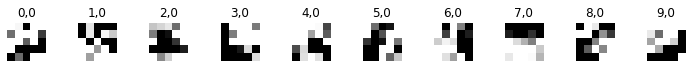

In [103]:
plot_weights(network_children, 0)

torch.Size([30, 1, 28, 28])


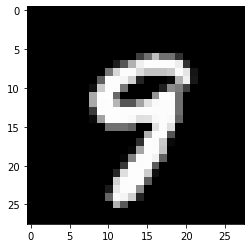

In [120]:
print(data1_part.shape)

img_n = 7

plt.imshow(data1_part[img_n][0], cmap='gray')
plt.show()

torch.Size([30, 10, 12, 12])


C:\Users\alpha\.conda\envs\pyTorch_1_5v2\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


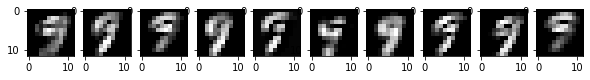

In [125]:
with torch.no_grad():
    data1_part_1l = network.forward_1l(data1_part)

    print(data1_part_1l.shape)
    nplots = data1_part_1l.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
#     npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))    
    #--------    
    
    for i in range(data1_part_1l.shape[1]):
        count += 1
        ax1 = fig.add_subplot(nrows, ncols, count)
            
        ax1.imshow(data1_part_1l[img_n][i], cmap='gray')
    fig.show()

t.shape[0]: 20; t.shape[1]: 20


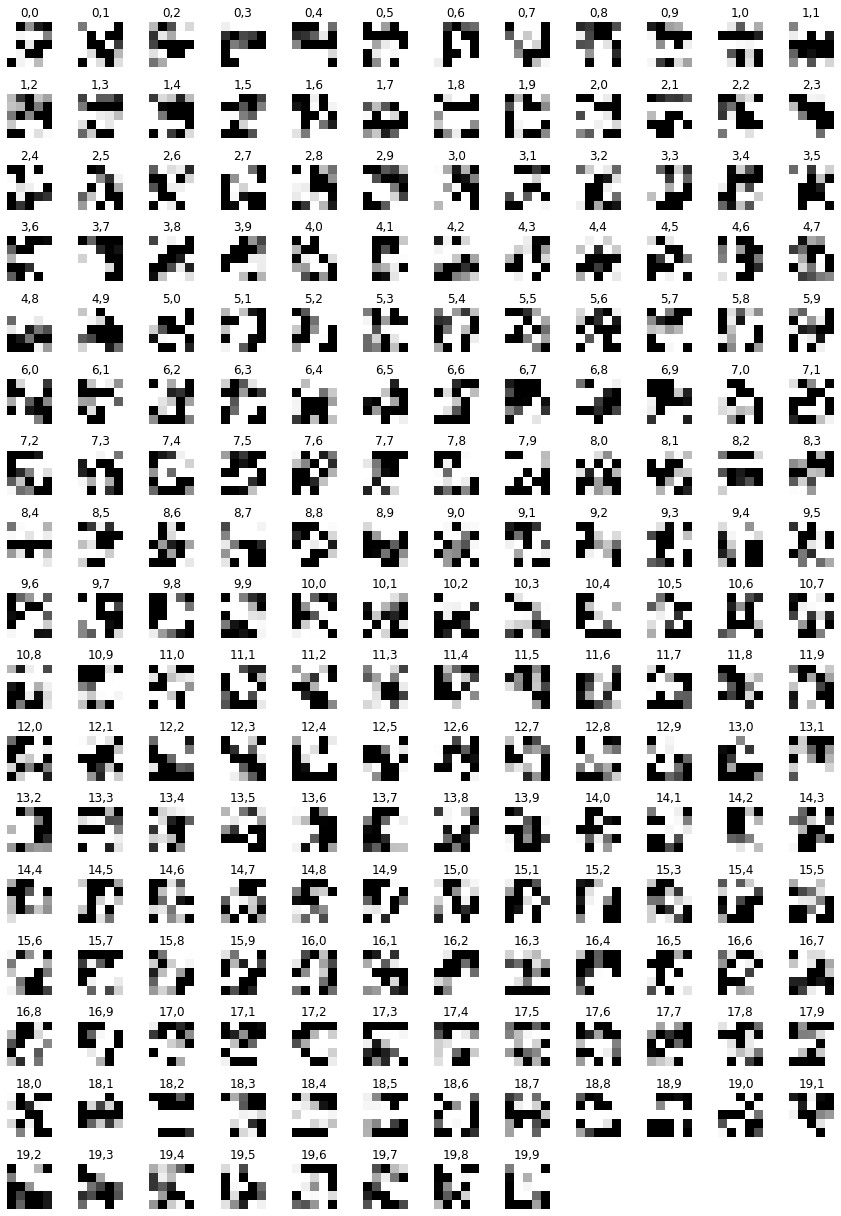

In [104]:
plot_weights(network_children, 1)

Примеры:
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.2-using-convnets-with-small-datasets.ipynb
* https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.4-visualizing-what-convnets-learn.ipynb

Вот несколько замечаний к полученным результатам:
* Первый слой действует как коллекция разных детекторов контуров. На этом этапе активация сохраняет почти всю информацию, имеющуюся в исходном изображении.
* По мере подъема вверх по слоям активации становятся все более абстрактными, а их визуальная интерпретация все более сложной. Они начинают кодировать высокоуровневые понятия, такие как «кошачье ухо» или «кошачий глаз». Высокоуровневые представления несут все меньше информации об исходном изображении и все больше — о классе изображения.
* Разреженность активаций увеличивается с глубиной слоя: в первом слое все фильтры активируются исходным изображением, но в последующих слоях все больше и больше остается пустых фильтров. Это означает, что шаблон, соответствующий фильтру, не обнаруживается в исходном изображении.

Глубокая нейронная сеть фактически действует как конвейер очистки информации, который получает неочищенные исходные данные (в данном случае изображения в формате RGB) и подвергает их многократным преобразованиям, фильтруя ненужную информацию (например, конкретный внешний вид изображения) и оставляя и очищая нужную (например, класс изображения).

Примерно так же люди и животные воспринимают окружающий мир: понаблюдав сцену в течение нескольких секунд, человек запоминает, какие абстрактные объекты присутствуют в ней (велосипед, дерево), но не запоминает всех деталей внешнего вида этих объектов. Фактически при попытке нарисовать велосипед по памяти, скорее всего, вам не удастся получить более или менее правильное изображение, даже при том, что вы могли видеть велосипеды тысячи раз

__Визуализация фильтров сверточных нейронных сетей__

Другой простой способ исследовать фильтры, полученные сетью, — отобразить визуальный шаблон, за который отвечает каждый фильтр. Это можно сделать методом градиентного восхождения в пространстве входов (gradient ascent in input space): выполняя градиентный спуск до значения входного изображения сверточной нейронной сети, максимизируя отклик конкретного фильтра, начав с пустого изображения. В результате получится версия входного изображения, для которого отклик данного фильтра был бы максимальным.

Задача решается просто: нужно сконструировать функцию потерь, максимизирующую значение данного фильтра данного сверточного слоя, и затем использовать стохастический градиентный спуск для настройки значений входного изображения, чтобы максимизировать значение активации. 

Эти визуальные представления фильтров могут многое рассказать о том, как слои сверточной нейронной сети видят мир: каждый слой в сети обучает свою коллекцию фильтров так, чтобы их входы можно было выразить в виде комбинации фильтров. Это напоминает преобразование Фурье, разлагающее сигнал в пакет косинусоидных функций. Фильтры в таких пакетах фильтров сверточной нейронной 
сети становятся все сложнее с увеличением слоя в модели:

* фильтры из первого слоя в модели (block1_conv1) кодируют простые направленные контуры и цвета (или, в некоторых случаях, цветные контуры);
* фильтры из block2_conv1 кодируют простые текстуры, состоящие из комбинаций контуров и цветов;
* фильтры в более высоких слоях начинают напоминать текстуры, встречающиеся в естественных изображениях, — перья, глаза, листья и т. д.

__Визуализация тепловых карт активации класса__

Визуализация карты активации класса (Class Activation Map, CAM): суть заключается в создании тепловых карт активации класса для входных изображений. 

Тепловая карта активации класса — это двумерная сетка оценок, связанных с конкретным выходным классом и вычисляемых для каждого местоположения в любом входном изображении. Эти оценки определяют, насколько важно каждое местоположение для рассматриваемого класса. Например, для изображения, передаваемого в сверточную нейронную  сеть, которая осуществляет классификацию кошек и собак, визуализация CAM позволяет сгенерировать тепловые карты для классов «кошка» и «собака», показывающие, насколько важными являются разные части изображения для этих классов.

Этот прием визуализации помогает ответить на два важных вопроса:
* Почему сеть решила, что на фотографии изображен именно данный тип объектов?
* Где на фотографии находится идентифицированный объект?

### Обработка последовательностей с помощью одномерных сверточных нейронных сетей

__Обработка последовательностей с помощью одномерных сверточных нейронных сетей__

Те же свойства сверточных нейронных сетей, которые делают их идеальным выбором для распознавания образов, прекрасно подходят для обработки последовательностей. Время можно рассматривать как пространственное измерение, подобно высоте или ширине двумерного изображения.

Одномерные сверточные нейронные сети с успехом могут состязаться с рекуррентными сетями в некоторых задачах обработки последовательностей, как правило, требуя меньше вычислительных ресурсов. Известно, что небольшие одномерные сверточные нейронные сети могут служить быстрой альтернативой рекуррентным сетям в простых задачах, таких как классификация текста и прогнозирование 
временных последовательностей.

__Как действует одномерная сверточная нейронная сеть__ 
Каждый временной интервал извлекается из временного шаблона во входной последовательности
<center> 
<img src="./img/conv_17.png" alt="Набор данных MNIST: примеры рукописных цифр" style="width: 400px;"/>
</center>

Одномерные сверточные слои способны распознавать локальные шаблоны в последовательности. Поскольку к каждому шаблону применяются одни и те же преобразования, тот или иной шаблон, найденный в некоторой позиции в предложении, позднее может быть опознан в другой позиции, что делает преобразования, выполняемые одномерными сверточными сетями, инвариантными (во времени). 

Например, одномерная сверточная сеть, обрабатывающая последовательность символов и использующая окно свертки с размером 5, способна запоминать слова или фрагменты слов длиной до 5 символов и распознавать эти слова в любом контексте во входной последовательности, — то есть одномерная сверточная сеть, обрабатывающая текст посимвольно, способна изучить морфологию слов.

```python
    # Слои, которые могут использоваться для построения одномерных сверточных сетей
    model.add(layers.Conv1D(32, 7, activation='relu'))
    model.add(layers.MaxPooling1D(5))
```

-----

In [1]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# загружаем данные MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
# превращаем каждую картинку в двумерный массив
batch_size, img_rows, img_cols = 64, 28, 28
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

In [4]:
# приводим данные к типу float32 и нормализуем их от 0 до 1
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train /= 255
X_test /= 255

In [5]:
# переводим правильные ответы в one-hot представление
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [6]:
# инициализируем модель
model = Sequential()

# добавляем сверточные слои
model.add(Convolution2D(32, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))
model.add(Convolution2D(64, 5, 5, border_mode="same", input_shape=input_shape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), border_mode="same"))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (5, 5), input_shape=(28, 28, 1..., padding="same")`
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same")`
  # Remove the CWD from sys.path while we load stuff.


In [7]:
# добавляем полносвязные слои
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [8]:
# компилируем и запускаем обучение
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=10, verbose=1, validation_data=(X_test, Y_test))
score = model.evaluate(X_test, Y_test, verbose=0)

# выводим результаты
print("Test score: %f" % score[0])
print("Test accuracy: %f" % score[1])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


C:\ProgramData\Anaconda3\lib\site-packages\keras-2.0.2-py3.6.egg\keras\models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 26s - loss: 0.1243 - acc: 0.9619 - val_loss: 0.0376 - val_acc: 0.9877
Epoch 2/10
60000/60000 [==============================] - 14s - loss: 0.0420 - acc: 0.9870 - val_loss: 0.0298 - val_acc: 0.9909
Epoch 3/10
60000/60000 [==============================] - 14s - loss: 0.0302 - acc: 0.9902 - val_loss: 0.0251 - val_acc: 0.9915
Epoch 4/10
60000/60000 [==============================] - 13s - loss: 0.0224 - acc: 0.9931 - val_loss: 0.0218 - val_acc: 0.9928
Epoch 5/10
60000/60000 [==============================] - 14s - loss: 0.0185 - acc: 0.9941 - val_loss: 0.0253 - val_acc: 0.9926
Epoch 6/10
60000/60000 [==============================] - 13s - loss: 0.0158 - acc: 0.9953 - val_loss: 0.0251 - val_acc: 0.9922
Epoch 7/10
60000/60000 [==============================] - 14s - loss: 0.0138 - acc: 0.9957 - val_loss: 0.0248 - val_acc: 0.9933
Epoch 8/10
60000/60000 [==============================

---

In [9]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from keras import models

(28, 28, 1) (28, 28)


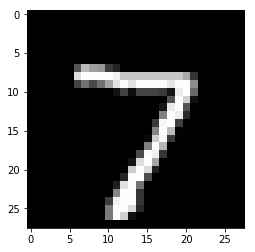

In [10]:
viz_fig = X_test[0] 
pixels = viz_fig.reshape((28, 28))
print(viz_fig.shape, pixels.shape)
plt.imshow(pixels, cmap='gray')
plt.show()

In [11]:
model.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [13]:
# Extracts the outputs of the top 4 layers:
layer_outputs = [layer.output for layer in model.layers[:4]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [14]:
viz_fig_v = viz_fig.copy()
viz_fig_v = np.expand_dims(viz_fig_v, axis=0)
viz_fig_v = viz_fig_v.astype("float32")
viz_fig_v /= 255

viz_fig_v.shape, input_shape

((1, 28, 28, 1), (28, 28, 1))

In [15]:
# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(viz_fig_v)

In [19]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


0


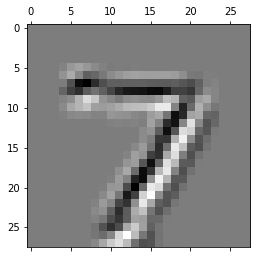

1


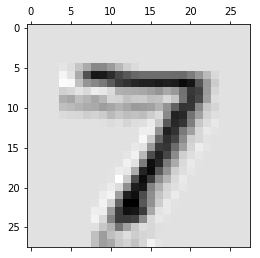

2


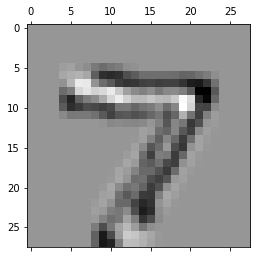

3


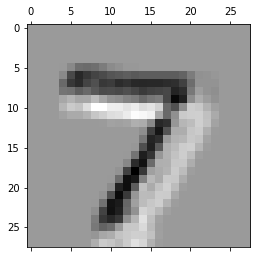

4


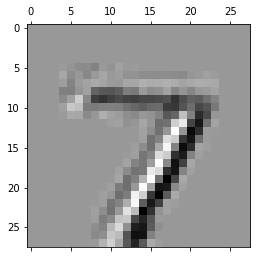

5


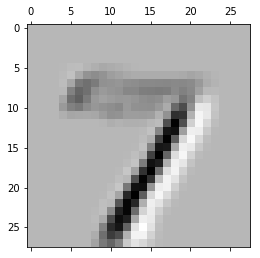

6


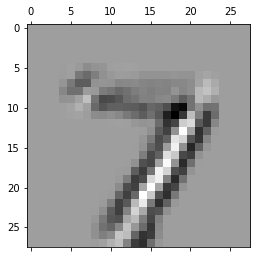

7


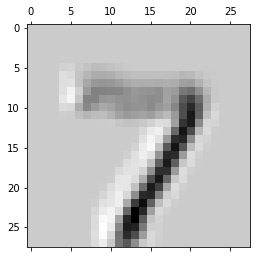

8


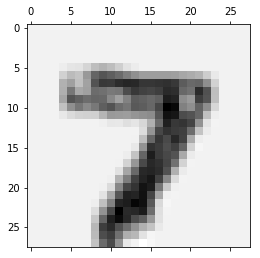

9


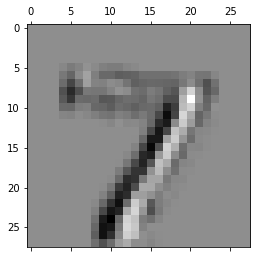

10


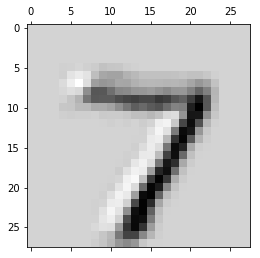

11


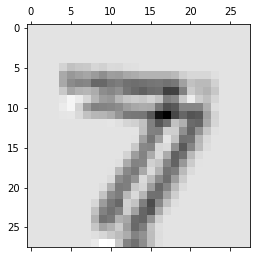

12


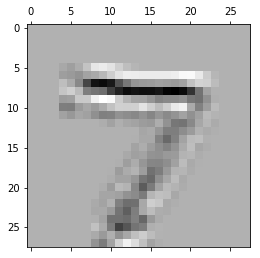

13


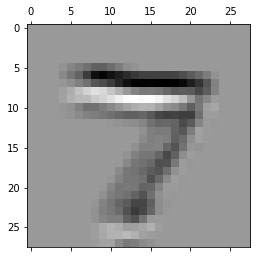

14


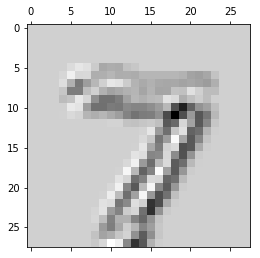

15


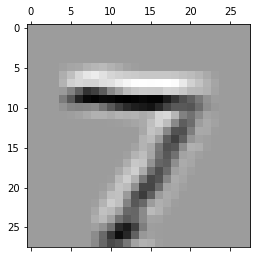

16


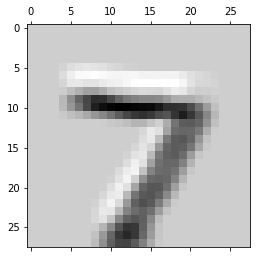

17


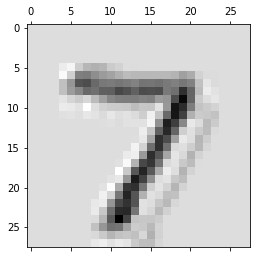

18


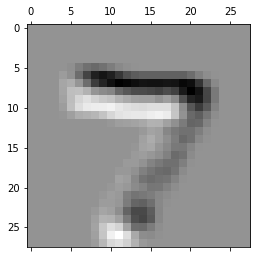

19


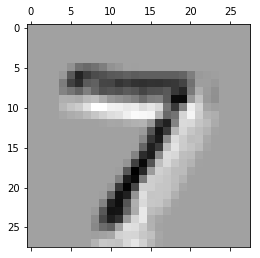

20


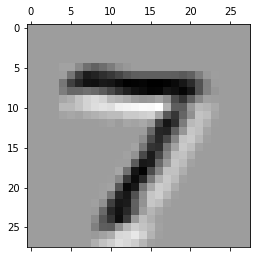

21


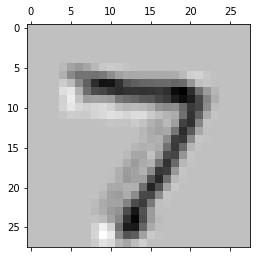

22


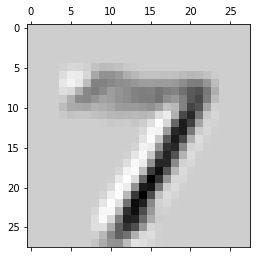

23


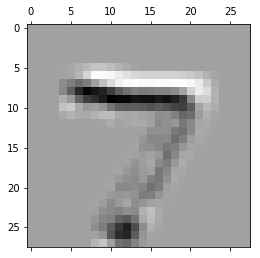

24


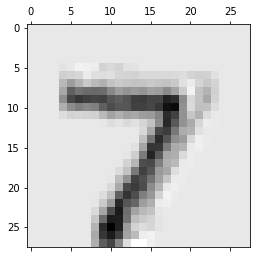

25


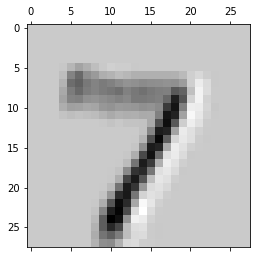

26


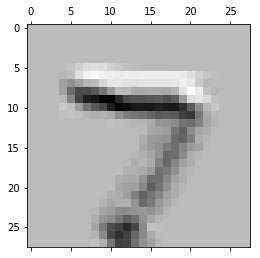

27


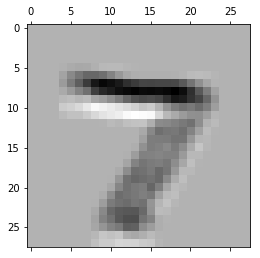

28


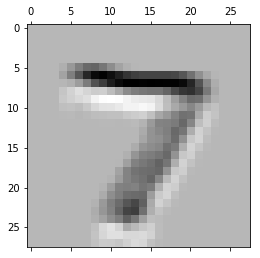

29


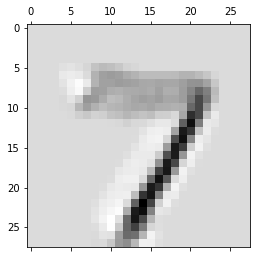

30


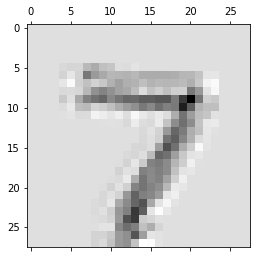

31


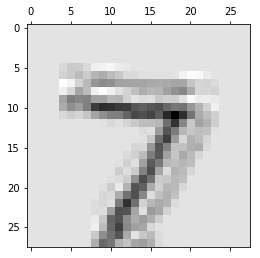

In [20]:
for i in range(32):
    print(i)
    plt.matshow(first_layer_activation[0, :, :, i], cmap='gray')
    plt.show()

In [16]:
second_layer_activation = activations[3]
print(second_layer_activation.shape)

(1, 14, 14, 64)


0


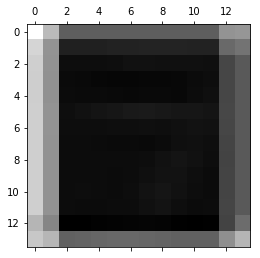

1


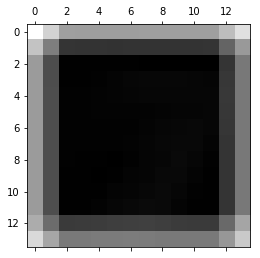

2


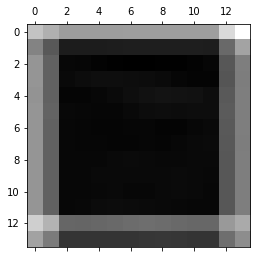

3


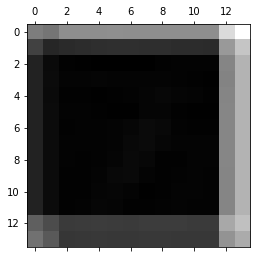

4


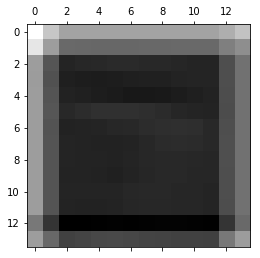

5


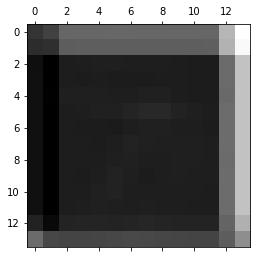

6


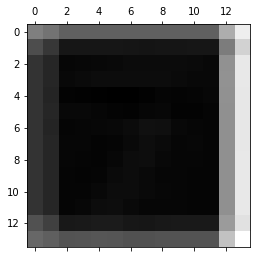

7


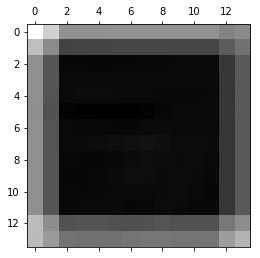

8


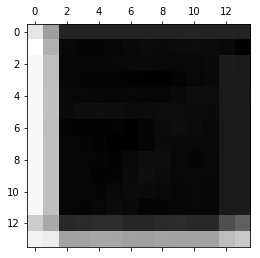

9


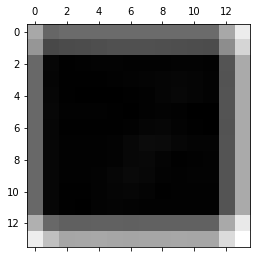

10


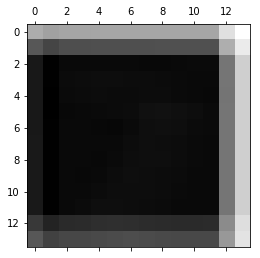

11


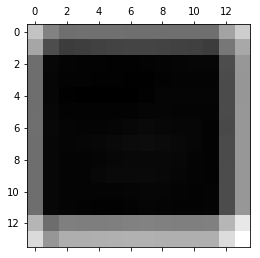

12


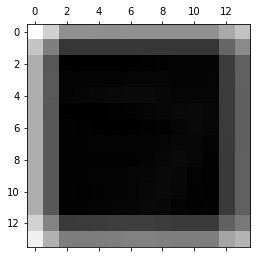

13


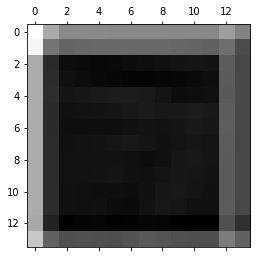

14


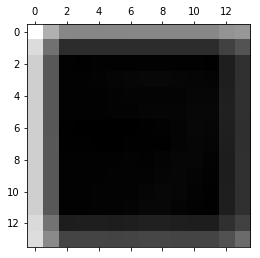

15


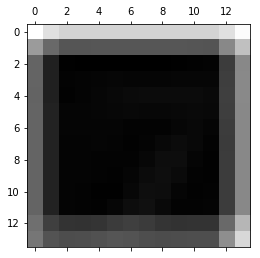

16


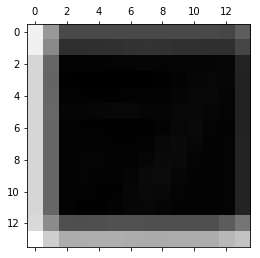

17


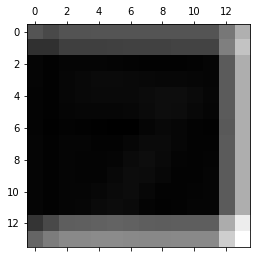

18


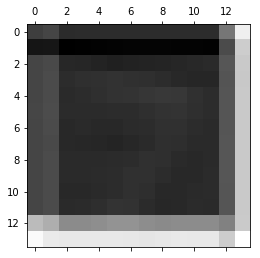

19


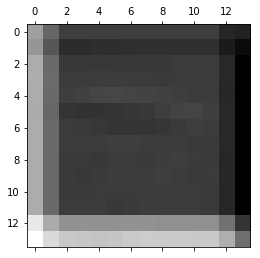

20


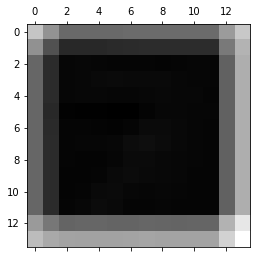

21


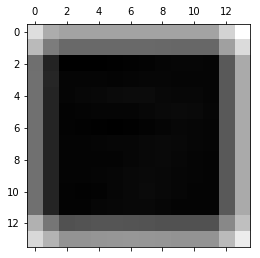

22


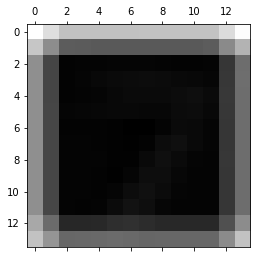

23


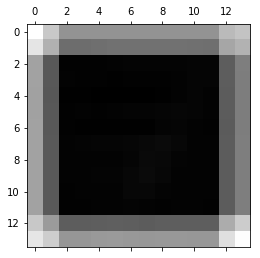

24


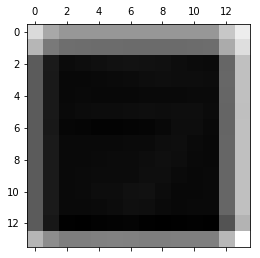

25


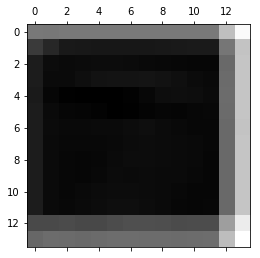

26


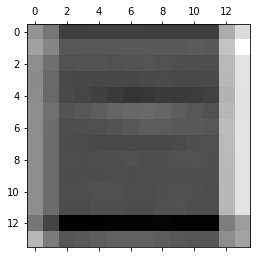

27


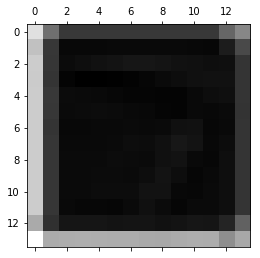

28


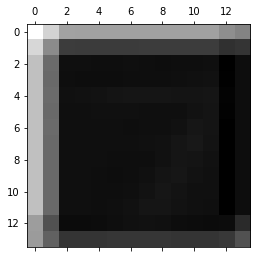

29


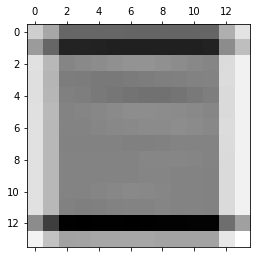

30


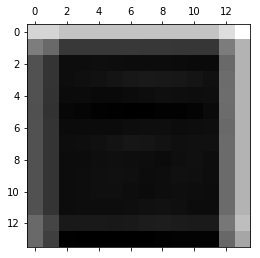

31


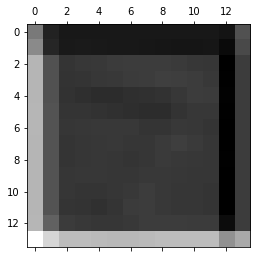

32


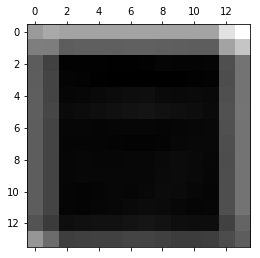

33


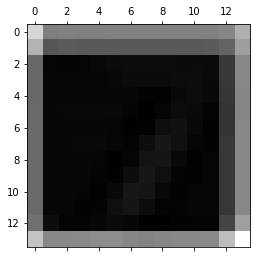

34


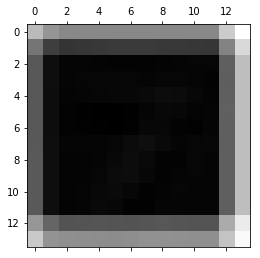

35


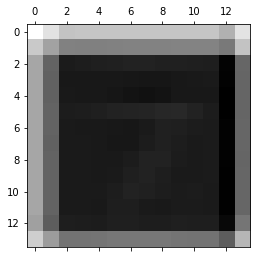

36


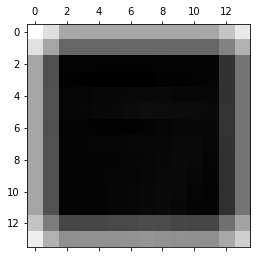

37


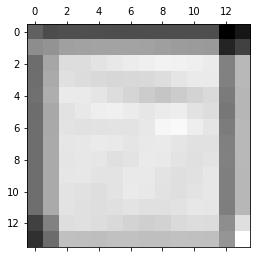

38


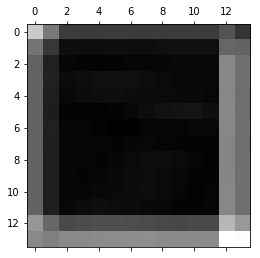

39


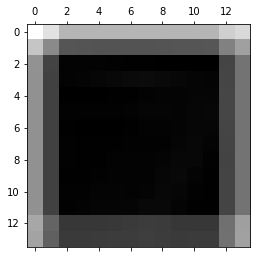

40


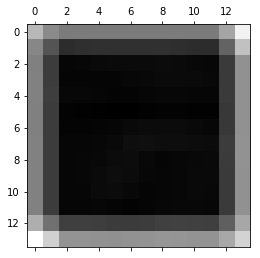

41


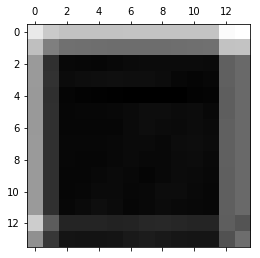

42


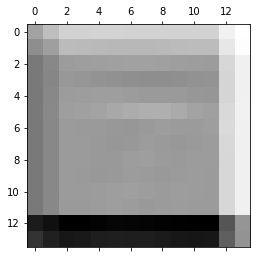

43


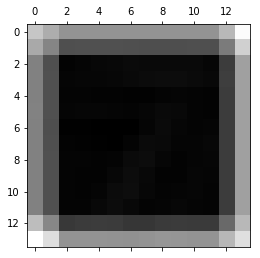

44


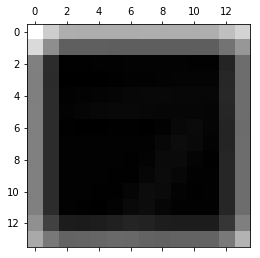

45


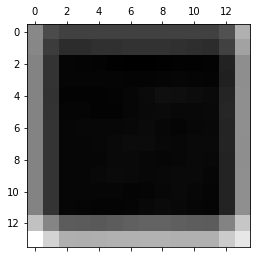

46


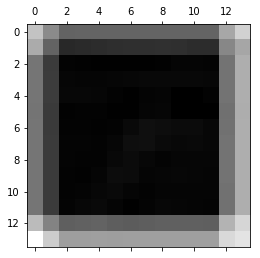

47


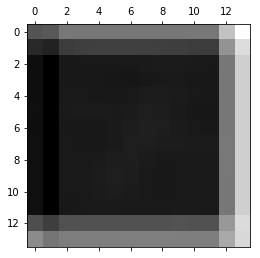

48


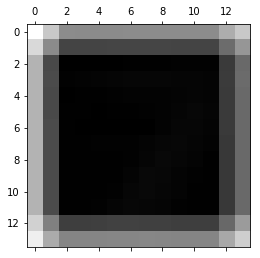

49


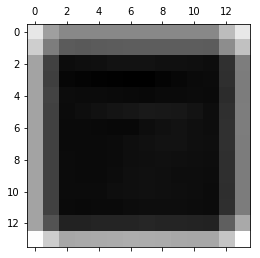

50


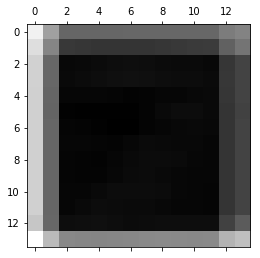

51


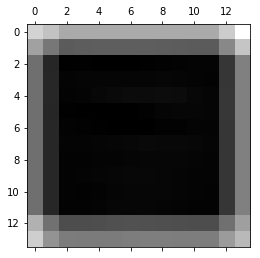

52


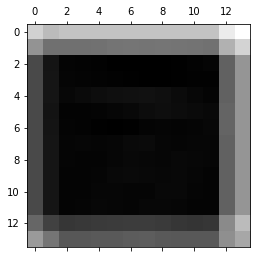

53


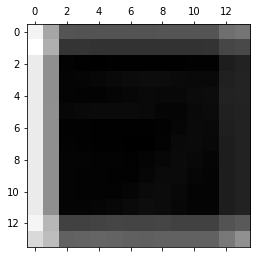

54


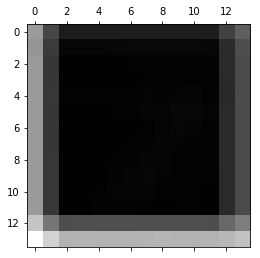

55


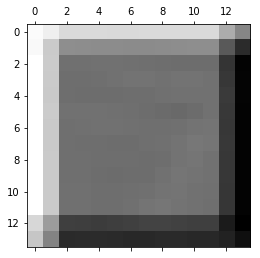

56


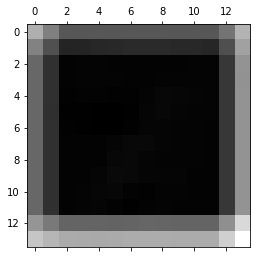

57


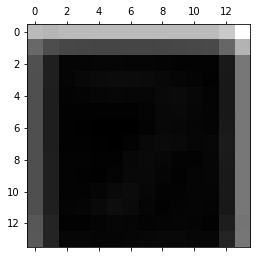

58


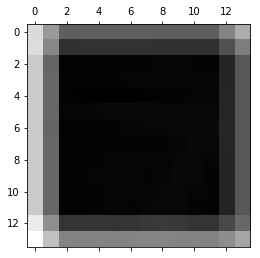

59


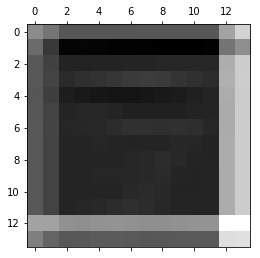

60


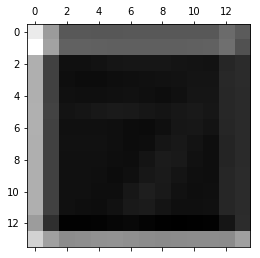

61


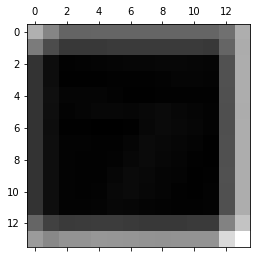

62


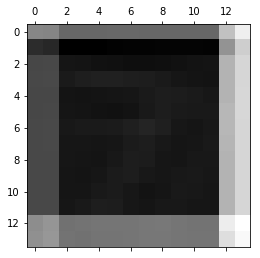

63


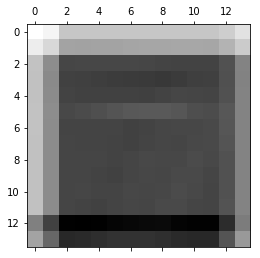

In [17]:
for i in range(64):
    print(i)
    plt.matshow(second_layer_activation[0, :, :, i], cmap='gray')
    plt.show()